## Analyzing Pertubation Distance and Response Distance

Ultimately, the thing we're actually interested in is covering the full range of possible **responses**, and there may or may not be any systematic relationship between the perturbation (prompt) and the response (assuming generally-similar semantic content across prompts.) If that's the case, we still might use perturbations because there could be random, non-systematic relationships, but we wouldn't want to focus on this idea of dimensionality reduction/full coverage of perturbations.

This is a first take at this problem. But there are two major limitations currently:
- I'm not sure if I'm thinking about generating perturbations correctly
- I'm not sure how to think about dimensionality reduction for either the prompt or the response, and if this is the way to do it

But if we can solve both of these in satisfying ways:
- We may not be able to 'go backward' from a low-density space to perturbation text, in which case we're better off just generating a lot of perturbations and then dropping the ones that are duplicative in that space. 

In [52]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import random
from functions import *

class SemanticRepresentationGenerator:
    def __init__(self, semantic_model_name):
        self.tokenizer, self.model = self.get_model(semantic_model_name)
        self.model.eval()  # Set the model to evaluation mode

    def get_model(self, model_name):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        return tokenizer, model

    def encode_text(self, text):
        encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        return model_output.last_hidden_state.mean(dim=1)

def generate_perturbations(model_name, provider, prompt, n, rephrase_level=None):
    perturbation_gen = PerturbationGenerator(model_name, provider, num_perturbations= n)
    # Correctly pass the 'n' and 'rephrase_level' arguments in the right order
    perturbations = perturbation_gen.get_perturbations(prompt, rephrase_level)
    return [(p, rephrase_level if rephrase_level else "original") for p in perturbations]

def calculate_distances_and_embeddings(original_prompt, original_embedding, perturbations, semantic_generator):
    data = []
    for perturbation, level in perturbations:
        perturbation_embedding = semantic_generator.encode_text(perturbation).numpy().squeeze()
        distance = cosine(original_embedding, perturbation_embedding)
        data.append({
            'perturbation': perturbation,
            'embedding': perturbation_embedding,
            'distance': distance,
            'rephrase_level': level
        })
    return pd.DataFrame(data)

def generate_and_process_perturbations(perturbation_model_name, original_prompt, n, semantic_model_name, rephrase_levels):
    semantic_generator = SemanticRepresentationGenerator(semantic_model_name)
    original_embedding = semantic_generator.encode_text(original_prompt).numpy().squeeze()

    result_data = [pd.DataFrame([{'perturbation': original_prompt, 'embedding': original_embedding, 'distance': 0, 'rephrase_level': "original"}])]
    for level in rephrase_levels:
        perturbations = generate_perturbations(perturbation_model_name[0], perturbation_model_name[1], original_prompt, n, level)
        level_df = calculate_distances_and_embeddings(original_prompt, original_embedding, perturbations, semantic_generator)
        result_data.append(level_df)

    return pd.concat(result_data, ignore_index=True)

def plot_tsne_with_colors(result_df):
    color_map = {'original': 'red', 'slightly': 'blue', 'moderate': 'green', 'extensive': 'orange'}
    colors = [color_map[level] for level in result_df['rephrase_level']]

    fig, ax = plt.subplots()
    scatter = ax.scatter(result_df['tsne-2d-one'], result_df['tsne-2d-two'], c=colors)

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=level, markerfacecolor=color, markersize=10) for level, color in color_map.items()]
    ax.legend(handles=legend_elements, title="Rephrase Level")

    ax.set_title('t-SNE plot of perturbations')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    plt.show()

def analyze_rephrase_distances(df):
    # Calculate mean distances for each rephrase level
    avg_distances = df.groupby('rephrase_level')['distance'].mean()

    # Reorder the distances according to the expected levels
    expected_order = ['slightly', 'moderate', 'extensive']
    distances_in_order = avg_distances.reindex(expected_order)

    # Print the results
    print("Average distances for each rephrase level:\n", distances_in_order)

    # Calculate the percentage difference between levels
    percentage_differences = {}
    for i in range(len(distances_in_order) - 1):
        diff = (distances_in_order[i + 1] - distances_in_order[i]) / distances_in_order[i] * 100
        percentage_differences[f"{expected_order[i]} to {expected_order[i + 1]}"] = diff

    # Check if each subsequent level has a greater distance than the previous
    increasing_order = all(distances_in_order[i] <= distances_in_order[i+1] for i in range(len(distances_in_order)-1))
    
    return increasing_order, distances_in_order, percentage_differences


def generate_llm_responses(llm_model_name, llm_provider, n_calls_per_category, result_df):
    # Get the unique rephrase_levels from result_df
    rephrase_levels = result_df['rephrase_level'].unique()

    # Create an empty DataFrame to store the results, including the existing columns
    llm_responses = pd.DataFrame(columns=['prompt', 'temperature', 'response', 'distance', 'rephrase_level'])

    # Generate responses for each rephrase level
    for rephrase_level in rephrase_levels:
        perturbations = result_df[result_df['rephrase_level'] == rephrase_level]['perturbation'].tolist()
        for _ in range(n_calls_per_category):
            selected_prompt = random.choice(perturbations)
            temperature = random.uniform(0,1)
            response = LLMUtility.call_model(llm_model_name, [{"role": "user", "content": selected_prompt}], llm_provider, temperature)
            response_content = response["choices"][0]["message"]["content"] if response else "No response"
            
            llm_responses = pd.concat([llm_responses, pd.DataFrame([{
    'prompt': selected_prompt,
    'temperature': temperature,
    'response': response_content,
    'distance': 0,
    'rephrase_level': rephrase_level
}])], ignore_index=True)

             
    return llm_responses

def apply_tsne_to_embeddings(result_df):
    embeddings = list(result_df['embedding'])
    embeddings_array = np.array(embeddings)
    tsne_results = apply_tsne(embeddings_array)

    result_df['tsne-2d-one'] = tsne_results[:,0]
    result_df['tsne-2d-two'] = tsne_results[:,1]
    return result_df

def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, perplexity=2, n_iter=300)  # These parameters can be tuned
    tsne_results = tsne.fit_transform(embeddings)
    return tsne_results

def add_embeddings_to_responses(model_responses_df, semantic_generator):
    # Create an empty list to store embeddings
    embeddings = []

    # Iterate over each response in the DataFrame
    for response in model_responses_df['response']:
        # Encode the response to get its embedding
        embedding = semantic_generator.encode_text(response).numpy().squeeze()
        embeddings.append(embedding)

    # Add the embeddings as a new column in the DataFrame
    model_responses_df['embedding'] = embeddings

    return model_responses_df

def calculate_correlation_between_perturbations_and_responses(perturbation_df, response_df):
    # Extract the original embeddings
    original_embedding = perturbation_df[perturbation_df['rephrase_level'] == 'original']['embedding'].iloc[0]
    
    # Calculate the average embedding of responses to the original prompt
    original_responses = response_df[response_df['rephrase_level'] == 'original']['embedding']
    average_original_response_embedding = np.mean(np.vstack(original_responses), axis=0)

    # Calculate distances for perturbations and responses
    perturbation_df['distance_from_original'] = perturbation_df['embedding'].apply(lambda x: cosine(x, original_embedding))
    response_df['distance_from_original_response'] = response_df['embedding'].apply(lambda x: cosine(x, average_original_response_embedding))

    # Merge the dataframes on the 'perturbation' column
    merged_df = perturbation_df.merge(response_df, left_on='perturbation', right_on='prompt', suffixes=('_perturbation', '_response'))
    merged_df = merged_df.loc[merged_df['rephrase_level_perturbation'] != "original"]

    # Add a check to ensure the column exists
    if 'distance_from_original' in merged_df.columns and 'distance_from_original_response' in merged_df.columns:
        # Calculate the correlation
        correlation = merged_df[['distance_from_original', 'distance_from_original_response']].corr().iloc[0, 1]
        print(f"Correlation between perturbation and response distances: {correlation}")
    else:
        print("Required columns not found in merged DataFrame")

    return merged_df


def plot_correlation_between_perturbations_and_responses(merged_df):
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['distance_from_original'], merged_df['distance_from_original_response'], alpha=0.7)
    plt.title('Correlation between Perturbation and Response Distances')
    plt.xlabel('Distance from Original Perturbation')
    plt.ylabel('Distance from Original Response')
    plt.grid(True)
    plt.show()


## Generate Perturbations

Here we're getting perturbations of a prompt and asking GPT-4 to rephrase them semantically by different amounts, or rephrase levels.
This will give us a DataFrame with the original prompt and n perturbations at each rephrase level.

In [2]:
perturbation_model = ['gpt-4', "OPENAI"]
semantic_model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'
n = 10
prompt = "Can you give me instructions on how to make pasta puttanesca?"
rephrase_levels = ["slightly", "moderate", 'extensive']
result_df = generate_and_process_perturbations(perturbation_model, prompt, n, semantic_model_name, rephrase_levels)


2024-01-04 17:04:41,712 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-04 17:04:41,712 - INFO - API call successful. Model: gpt-4, Provider: OPENAI
2024-01-04 17:04:56,690 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-04 17:04:56,695 - INFO - API call successful. Model: gpt-4, Provider: OPENAI
2024-01-04 17:05:14,840 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-04 17:05:14,845 - INFO - API call successful. Model: gpt-4, Provider: OPENAI


### This is what the DataFrame looks like

In [14]:
result_df.head()

,perturbation,embedding,distance,rephrase_level,tsne-2d-one,tsne-2d-two
0,Can you give me instructions on how to make pa...,"[-0.24752232, -0.1547963, -0.07296216, 0.04272...",0.000000,original,-46.248196,-24.801006
1,1. Could you guide me through the process of m...,"[-0.16069777, -0.14337607, -0.09973024, 0.0441...",0.096944,slightly,32.650436,-51.545128
2,2. Can you provide a step-by-step guide for pr...,"[-0.16865228, -0.05358472, -0.09868454, -0.005...",0.076907,slightly,43.814201,27.213923
3,3. Would you mind explaining how to cook pasta...,"[-0.17482822, -0.08448243, -0.086957864, 0.027...",0.165916,slightly,-39.320400,14.508770
4,4. Can you show me the way to make pasta putta...,"[-0.2154669, -0.14766344, -0.08594462, 0.08261...",0.046459,slightly,-36.061092,-21.784603


### We now use the semantic model above to get word embeddings and then further reduce dimensionality via tsne. 

In [4]:
result_df = apply_tsne_to_embeddings(result_df)

### And then we plot to see how related the rephrase level is from the distance from the original prompt in this space

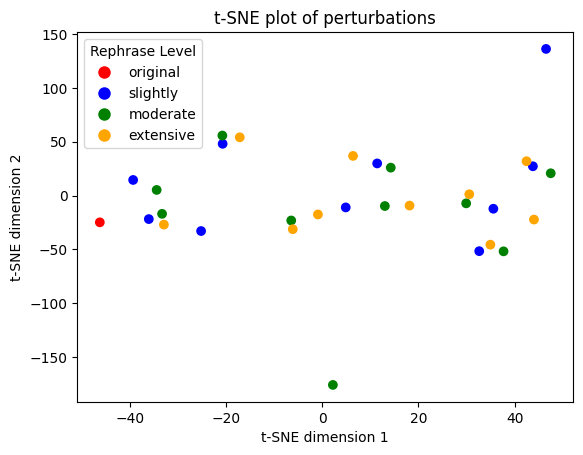

In [5]:
plot_tsne_with_colors(result_df)

### Then we get the average distances and whether we see increase with level of rephrasing. (Sometimes they do and sometimes they don't, but it's never huge)

In [6]:
order_correct, distances, percentage_diffs = analyze_rephrase_distances(result_df)
print("\nDo the distances increase with the level of rephrasing?", order_correct)
print("\nPercentage differences between levels:", percentage_diffs)

Average distances for each rephrase level:
 rephrase_level
slightly     0.095009
moderate     0.098107
extensive    0.099857
Name: distance, dtype: float64

Do the distances increase with the level of rephrasing? True

Percentage differences between levels: {'slightly to moderate': 3.261510564253288, 'moderate to extensive': 1.7831584715853936}


C:\Users\abiga\AppData\Local\Temp\ipykernel_73200\3458697745.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = (distances_in_order[i + 1] - distances_in_order[i]) / distances_in_order[i] * 100
C:\Users\abiga\AppData\Local\Temp\ipykernel_73200\3458697745.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  increasing_order = all(distances_in_order[i] <= distances_in_order[i+1] for i in range(len(distances_in_order)-1))


### Now we use those new perturbations to make calls to an LLM and get back responses. We randomly select perturbations, stratifying by level of rephrase and also randomizing temperature

In [54]:
llm_model_name = "gpt-3.5-turbo"
llm_provider = "OPENAI"
# Randomly select n prompts for the LLM model calls
n_calls_per_category = 50
# Display the DataFrame
model_responses = generate_llm_responses(llm_model_name, llm_provider, n_calls_per_category, result_df)

2024-01-05 14:47:27,790 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-05 14:47:27,804 - INFO - API call successful. Model: gpt-3.5-turbo, Provider: OPENAI
C:\Users\abiga\AppData\Local\Temp\ipykernel_73200\1264981946.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  llm_responses = pd.concat([llm_responses, pd.DataFrame([{
2024-01-05 14:47:34,791 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-05 14:47:34,797 - INFO - API call successful. Model: gpt-3.5-turbo, Provider: OPENAI
2024-01-05 14:47:42,395 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-05 14:47:42,400 - INFO - API call successful

### This is what it looks like

In [55]:
model_responses.head()

,prompt,temperature,response,distance,rephrase_level
0,Can you give me instructions on how to make pa...,0.909318,Certainly! Here's a recipe and step-by-step in...,0,original
1,Can you give me instructions on how to make pa...,0.652027,Certainly! Here's a simple recipe for making P...,0,original
2,Can you give me instructions on how to make pa...,0.178691,Certainly! Here's a step-by-step guide on how ...,0,original
3,Can you give me instructions on how to make pa...,0.718966,Sure! Here's a recipe and instructions on how ...,0,original
4,Can you give me instructions on how to make pa...,0.487993,Certainly! Here's a simple recipe for making P...,0,original


### Now we do the same thing as with the perturbations: we add embeddings to the responses, apply tsne, and plot to see if there's a relationship between rephrase level of the perturbation that led to the response and distance from the responses that were generated via the original prompt

In [56]:
semantic_generator = SemanticRepresentationGenerator(semantic_model_name)
model_responses_df_with_embeddings = add_embeddings_to_responses(model_responses, semantic_generator)

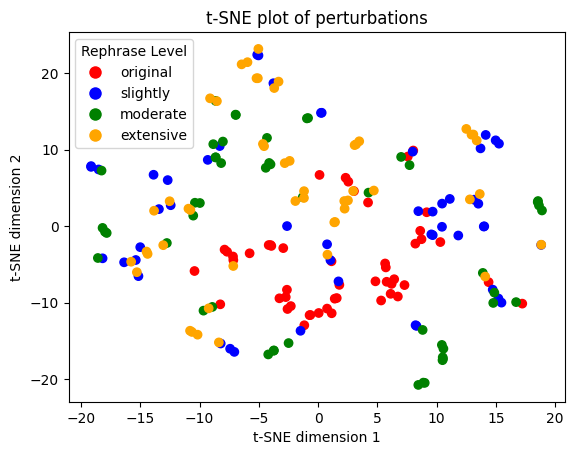

In [57]:
model_responses_df_with_tsne = apply_tsne_to_embeddings(model_responses_df_with_embeddings)
model_responses_df_with_tsne
plot_tsne_with_colors(model_responses_df_with_tsne)

### Different method: let's look at relationship between prompt distance and response distance just using the embeddings, not t-sne

Correlation between perturbation and response distances: 0.09861451268165301


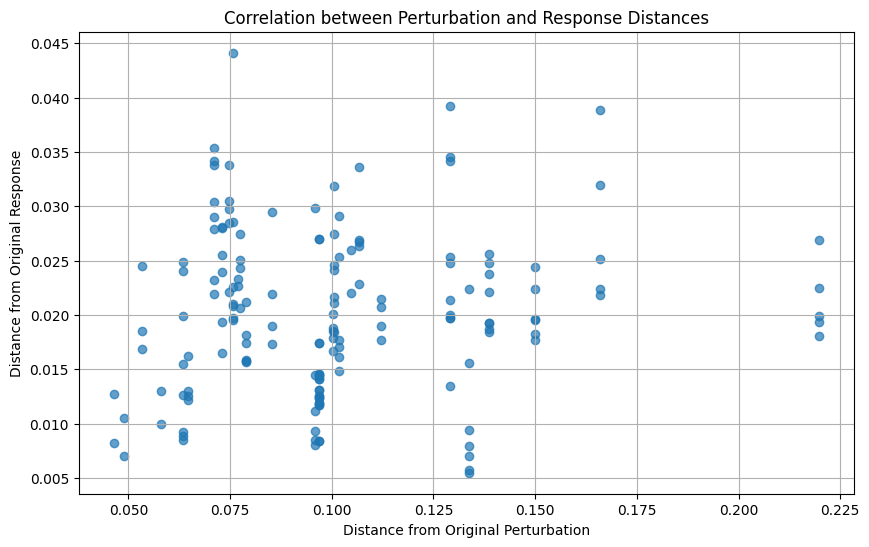

In [58]:
merged_df = calculate_correlation_between_perturbations_and_responses(result_df, model_responses_df_with_embeddings)
plot_correlation_between_perturbations_and_responses(merged_df)